In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

### Read the data

In [2]:
data = pd.read_csv('CDNOW_master/CDNOW_master.txt',
                          sep = '\s+',
                          names = ['customerID', 'date', 'quantity', 'sales'])

In [3]:
data.head()

,customerID,date,quantity,sales
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   customerID  69659 non-null  int64  
 1   date        69659 non-null  int64  
 2   quantity    69659 non-null  int64  
 3   sales       69659 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


In [5]:
# Convert date from int64 to datetime format
data['date'] = data['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   customerID  69659 non-null  int64         
 1   date        69659 non-null  datetime64[ns]
 2   quantity    69659 non-null  int64         
 3   sales       69659 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 2.1 MB


In [7]:
data.head()

,customerID,date,quantity,sales
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76


In [8]:
# Let’s take a closer look at the data we will need to manipulate.
print('Transactions timeframe from {} to {}'.format(data['date'].min().date(), data['date'].max().date()))
print('{:,} transactions don\'t have a customer id'.format(data[data.customerID.isnull()].shape[0]))
print('{:,} unique customerID_sample'.format(len(data.customerID.unique())))

Transactions timeframe from 1997-01-01 to 1998-06-30
0 transactions don't have a customer id
23,570 unique customerID_sample


In [9]:
# check for null values
data.isnull().sum()

customerID    0
date          0
quantity      0
sales         0
dtype: int64

- No null values

In [10]:
# check for duplicate rows
data.duplicated().sum()

255

- Remove duplicate

In [11]:
data = data.drop_duplicates(keep='first')

In [12]:
data.shape

(69404, 4)

In [13]:
data.describe()

,customerID,quantity,sales
count,69404.000000,69404.000000,69404.000000
mean,11468.913766,2.414558,35.963097
std,6814.368605,2.336528,36.318489
min,1.000000,1.000000,0.000000
25%,5509.000000,1.000000,14.490000
50%,11410.000000,2.000000,25.980000
75%,17261.000000,3.000000,43.720000
max,23570.000000,99.000000,1286.010000


### EDA

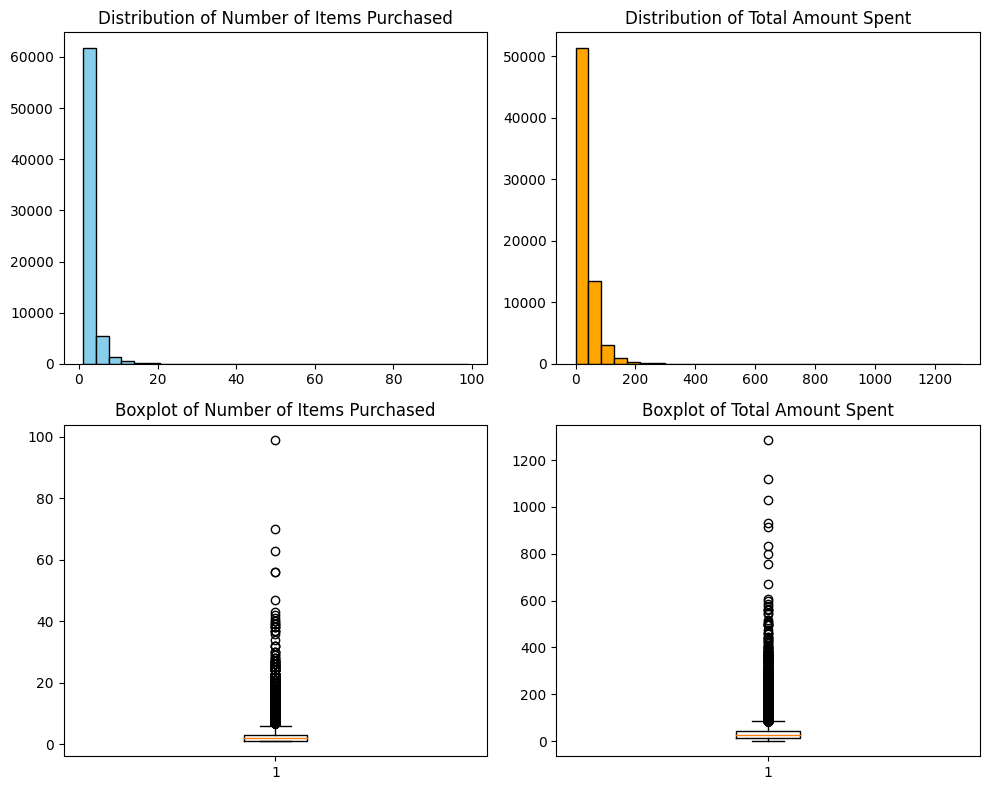

In [14]:
# Visualize the distribution of the columns using histograms
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes[0, 0].hist(data['quantity'], bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Number of Items Purchased')
axes[0, 1].hist(data['sales'], bins=30, color='orange', edgecolor='black')
axes[0, 1].set_title('Distribution of Total Amount Spent')
axes[1, 0].boxplot(data['quantity'])
axes[1, 0].set_title('Boxplot of Number of Items Purchased')
axes[1, 1].boxplot(data['sales'])
axes[1, 1].set_title('Boxplot of Total Amount Spent')
plt.tight_layout()
plt.show()

- Distribution of the number of items purchased is skewed to the right, with most customers purchasing between 1 and 5 items.
- Distribution of the total amount spent is also skewed to the right, with most customers spending less than $100.
- Quantity and Sales have outliers

In [15]:
# Consumption trend of customers
data_month = data.date.values.astype('datetime64[M]')
data['month'] = data_month
data_1 = data.pivot_table(index='month', 
                              values=['customerID','quantity','sales'],
                              aggfunc={
                                  'customerID':'count',
                                  'quantity':'sum',
                                  'sales':'sum'
                              })
data_1.sort_values(by='sales', ascending=False).head()

,customerID,quantity,sales
month,,,
1997-03-01,11574,26118,392588.21
1997-02-01,11247,24893,379191.50
1997-01-01,8914,19402,298793.76
1997-04-01,3775,9718,142668.66
1997-07-01,2930,8116,121886.85


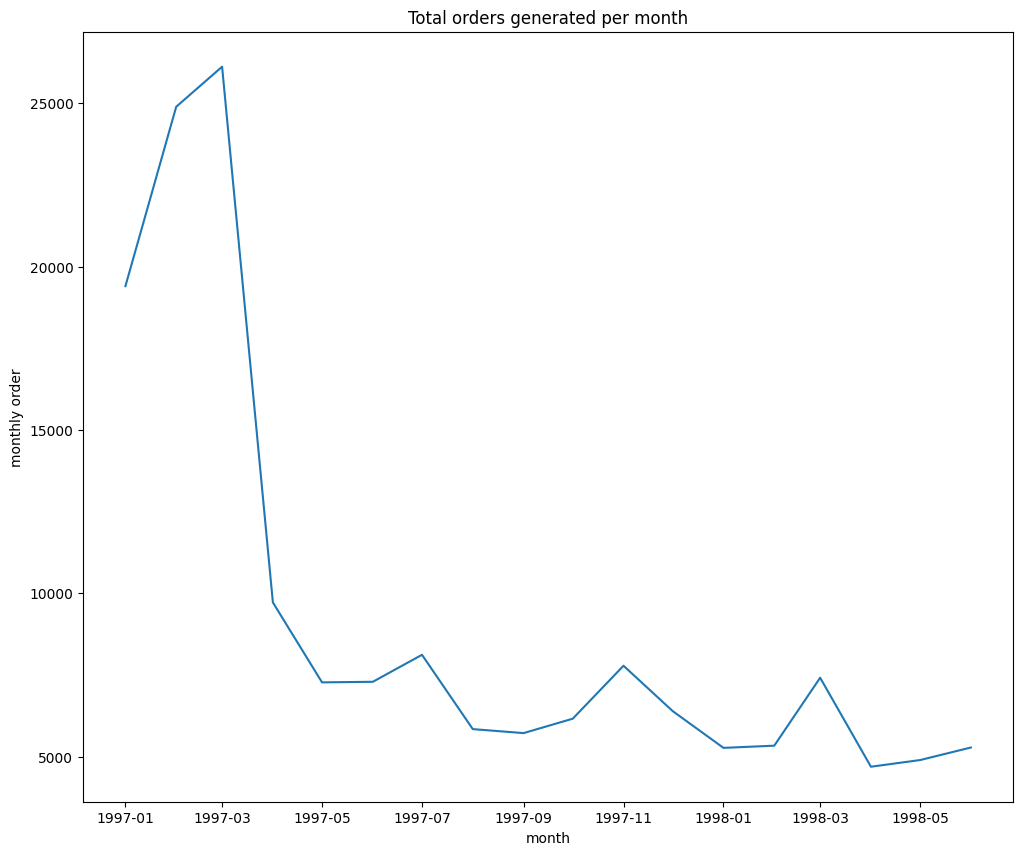

In [16]:
# Total orders generated per month
plt.figure(figsize=(12, 10))
plt.plot(data_1['quantity'])
plt.xlabel('month')
plt.ylabel('monthly order')
plt.title('Total orders generated per month')
plt.show()

- Tháng 3/1997 có tổng orders cao nhất

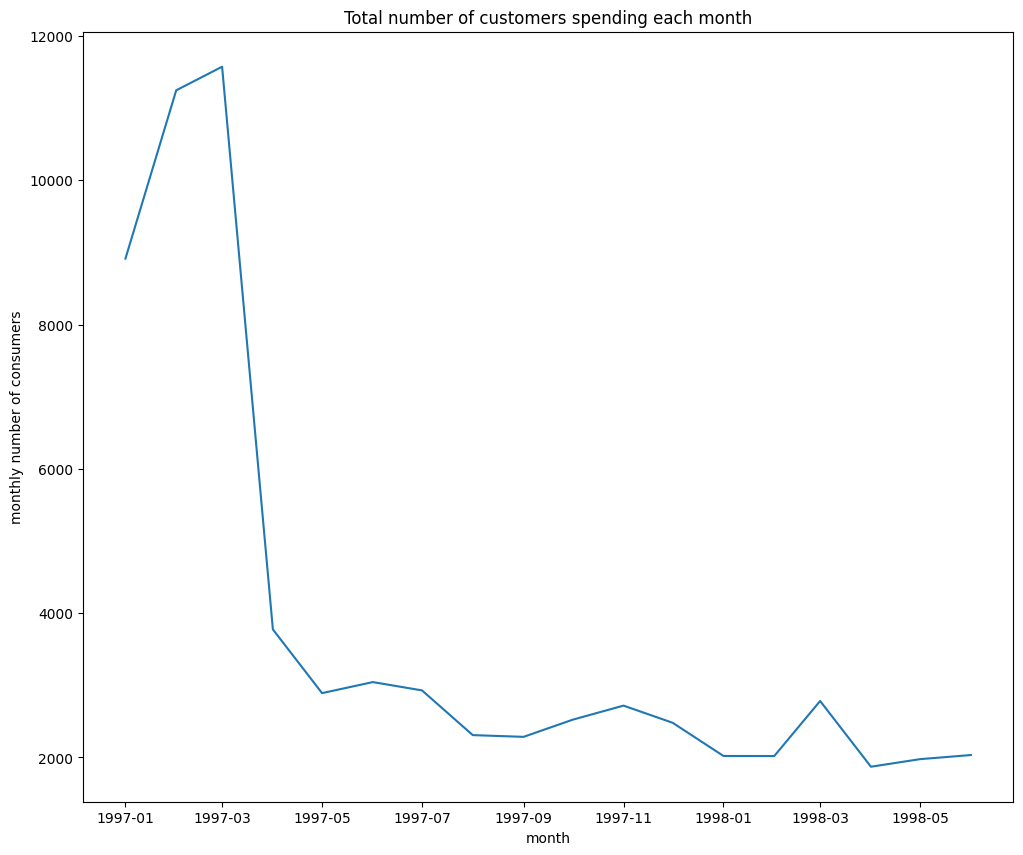

In [17]:
# Total number of customers spending each month
plt.figure(figsize=(12, 10))
plt.plot(data_1['customerID'])
plt.xlabel('month')
plt.ylabel('monthly number of consumers')
plt.title('Total number of customers spending each month')
plt.show()

- Có khoảng 11000 customers trong tháng 3/1997

In [18]:
data_2 = data.pivot_table(index='customerID',
                               values='date',
                               aggfunc={
                                  'date': 'min'
                               })
data_2.rename(
    columns={
        'date': 'first_time_purchasing'
    },
    inplace = True
)
data_2.head()

,first_time_purchasing
customerID,
1,1997-01-01
2,1997-01-12
3,1997-01-02
4,1997-01-01
5,1997-01-01


In [19]:
customer_firstdate = data_2.iloc[:,0].value_counts()
customer_firstdate.head()

1997-02-08    363
1997-02-24    347
1997-02-04    346
1997-02-06    346
1997-03-04    340
Name: first_time_purchasing, dtype: int64

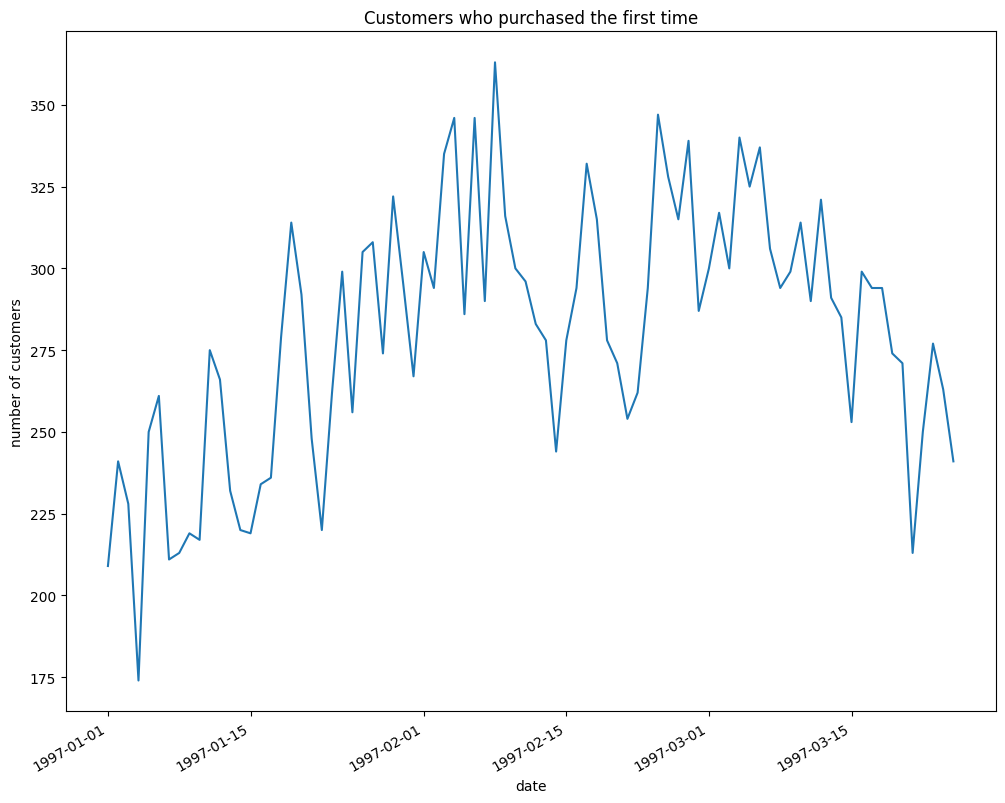

In [20]:
plt.figure(figsize=(12, 10))
customer_firstdate.plot()
plt.xlabel('date')
plt.ylabel('number of customers')
plt.title('Customers who purchased the first time')
plt.show()

- 1997-02-08 có lượng khách hàng mới nhiều nhất với khoảng 350 khách hàng

In [21]:
data_3 = data.pivot_table(index='customerID',
                               values='date',
                               aggfunc={
                                  'date': 'max'
                               })
data_3.rename(
    columns={
        'date': 'last_time_purchasing'
    },
    inplace = True
)
data_3.head()

,last_time_purchasing
customerID,
1,1997-01-01
2,1997-01-12
3,1998-05-28
4,1997-12-12
5,1998-01-03


In [22]:
# Number of customers who made the last purchase on the same date
customer_lastdate = data_3.iloc[:,0].value_counts()
customer_lastdate.head()

1997-02-08    221
1997-03-12    213
1997-02-04    210
1997-03-06    204
1997-02-27    202
Name: last_time_purchasing, dtype: int64

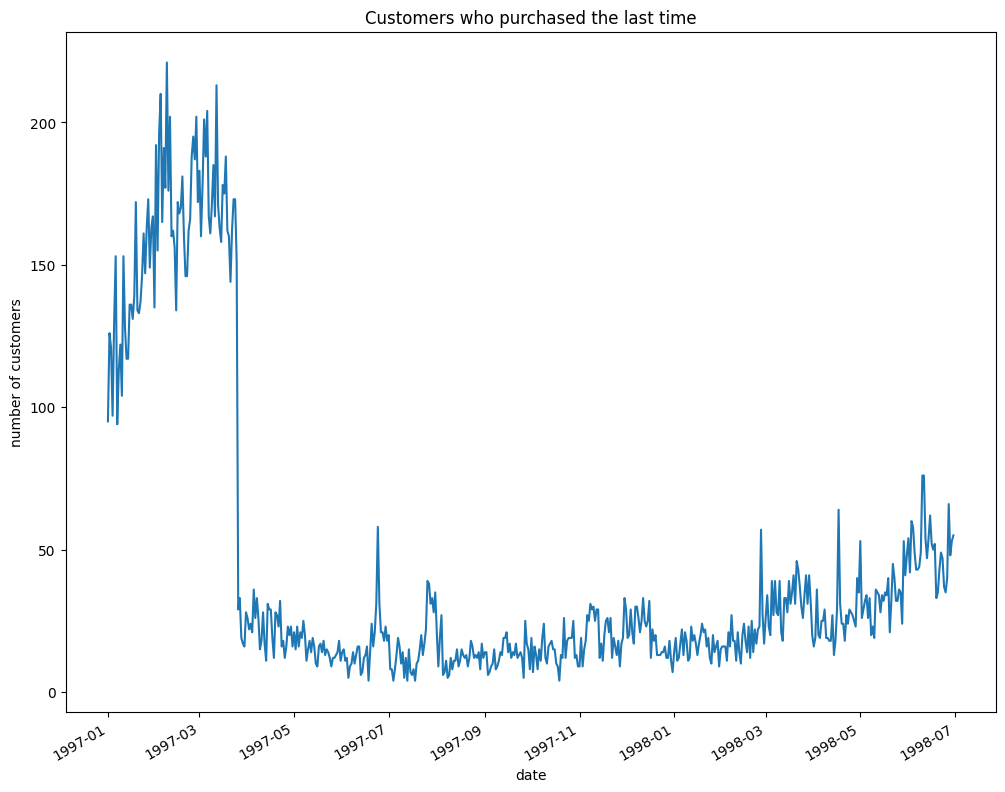

In [23]:
plt.figure(figsize=(12, 10))
customer_lastdate.plot()
plt.xlabel('date')
plt.ylabel('number of customers')
plt.title('Customers who purchased the last time')
plt.show()

- Từ tháng 1/1997 tới tháng 4/1997 có lượng khách hàng made the last purchased cao hơn so với những tháng sau đó

In [24]:
data.shape

(69404, 5)

In [25]:
data.drop('month', axis = 1, inplace = True)

In [26]:
data.to_csv('Files/Data_cleaned.csv')